In [1]:
import charts_function_list
from mpl_toolkits.mplot3d import Axes3D
import os
from PIL import Image

In [2]:
_,data,outputs = charts_function_list.folder_setup()
lego = os.path.join(data,'lego-database')
os.chdir(lego)

In [3]:
lego = os.path.join(data,'lego-database')
df_values = [x.split('.csv')[0] for x in os.listdir(lego)] 
df_values.remove('downloads_schema.png') #known non .csv

#set dictionary of all csvs
lego_d = {i:pd.read_csv(i+'.csv') for i in df_values}

In [4]:
#function to convert hex to rgb
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

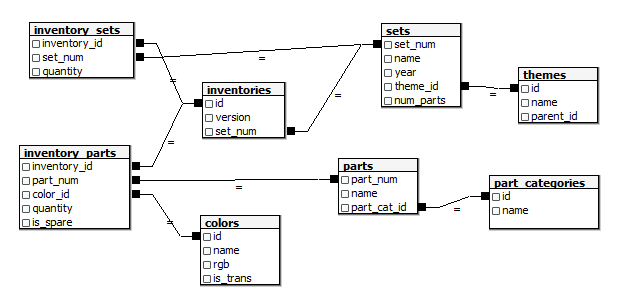

In [5]:
Image.open('downloads_schema.png')

## Create new combined frames

In [6]:
combined_sets = pd.merge(lego_d["sets"],lego_d["inventories"],on='set_num',how='left')
combined_sets = pd.merge(combined_sets,lego_d["themes"],left_on='theme_id',right_on='id',how='left',suffixes=('_of_set','_of_theme'))

#combining parts and other tables
combined_parts = pd.merge(lego_d["inventory_parts"],lego_d["parts"],on='part_num',how='left') #merging this way. the reverse reveals some parts not in the inventory_parts
combined_parts = pd.merge(combined_parts, lego_d["part_categories"],left_on='part_cat_id',right_on='id',how='left',suffixes=('_of_part','_of_part_category'))
combined_parts = pd.merge(combined_parts,lego_d["colors"],left_on='color_id',right_on='id',how='left')
combined_parts = combined_parts.drop(['id_x','id_y'],axis=1)

#combine it all
master_lego = pd.merge(combined_sets,combined_parts,left_on='id_of_set',right_on='inventory_id',how='left')

In [127]:
#count of parts by color
part_count = master_lego.pivot_table('quantity',index='rgb',aggfunc='sum').reset_index()
part_count = pd.concat([part_count,pd.DataFrame(list(part_count.reset_index()['rgb'].apply(hex_to_rgb)),columns=['R','G','B'])],
          axis=1)

In [174]:
part_count['quantity'].max()

398948.0

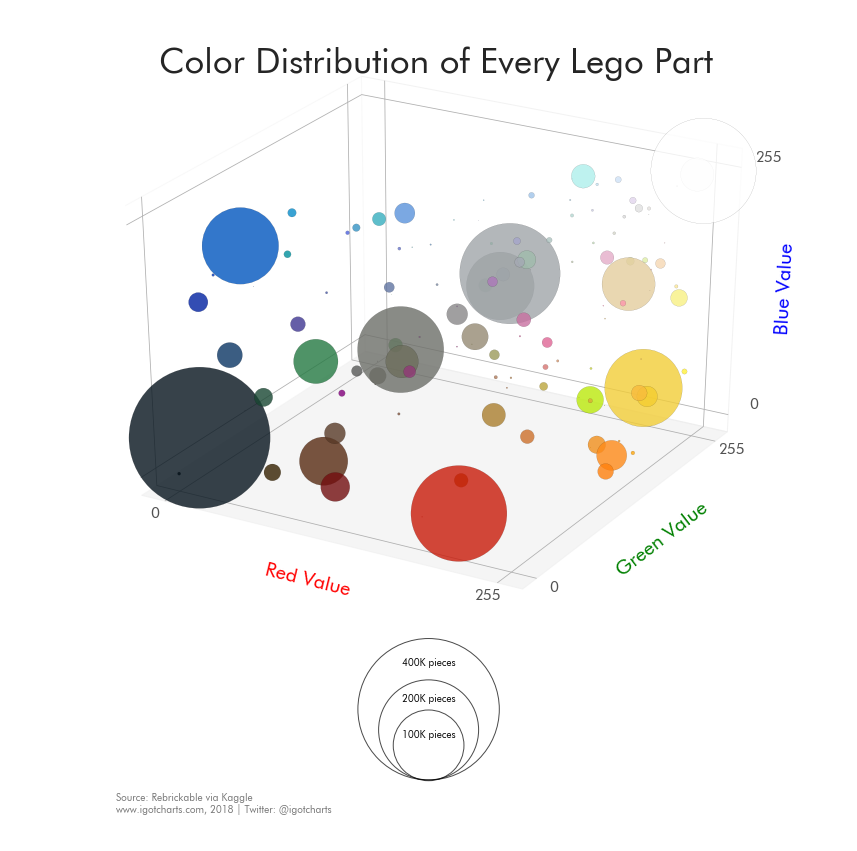

In [210]:
os.chdir(outputs)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14,12))
fig.suptitle('Color Distribution of Every Lego Part',size=35,color='#252525',x=.52)
fig.subplots_adjust(top=.99)
#ax2 = plt.subplot2grid((4,3), (3,1), colspan=1,rowspan=2)
ax = plt.subplot2grid((5,3), (0,0), colspan=3,rowspan=4,projection='3d')

ax.scatter(part_count['R'],part_count['G'],part_count['B'],s=part_count['quantity']/20,c='#'+part_count['rgb'],alpha=.8,
           edgecolor='black',linewidth=.1)

#ax.scatter(255,255,255,s=part_count[part_count['rgb']=='FFFFFF']['quantity'].values/20,c='#FFFFFF',alpha=.8,
 #          edgecolor='black',linewidth=.5)

ax.set_xlabel('Red Value',fontsize=20,color='red')
ax.set_ylabel('Green Value',fontsize=20,color='green')
ax.set_zlabel('Blue Value',fontsize=20,color='blue')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = True
#ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
ax.w_xaxis.set_ticks([0,255])
ax.w_yaxis.set_ticks([0,255])
ax.w_zaxis.set_ticks([0,255])
ax.w_xaxis.set_ticks_position('none') 

for t1 in ax.xaxis.get_ticklines():
    t1.set_visible(False)
    
for t1 in ax.yaxis.get_ticklines():
    t1.set_visible(False)
    
for t1 in ax.zaxis.get_ticklines():
    t1.set_visible(False)

ax.tick_params(labelsize=15,labelcolor='#525252',labeltop=True,
               labelbottom=False,labelleft=False,labelright=True,pad=8)



#create legend


ax2 = plt.subplot2grid((4,3), (3,1), colspan=1,rowspan=2)
ax2.set_xticks([])
ax2.set_yticks([])
for v,p,p2 in zip([400000,200000,100000],[1,.8,.65],[1.5,1.15,.8]):
    ax2.scatter(.5,p,c='',edgecolor='black',s=v/20,clip_on=False,alpha=.7)
    ax2.text(.5,p2,str(int(v/1000))+'K'+' pieces',ha='center',va='top')


ax2.text(.1,-.3,s='Source: Rebrickable via Kaggle',fontsize=10,color='#525252',alpha=.8,transform=ax.transAxes)
ax2.text(.1,-.32,s='www.igotcharts.com, 2018 | Twitter: @igotcharts',fontsize=10,color='#525252',alpha=.8,transform=ax.transAxes)

charts_function_list.chart_save('lego_colors',dpi=150)

#### Export master dataset

In [138]:
master_lego.to_csv('master_lego_data.csv')

### A look into the major brick categories and color

In [233]:
master_lego['name_of_part'] = master_lego['name_of_part'].fillna('-')

In [334]:
major_bricks = master_lego[master_lego['name_of_part'].isin(['Brick 1 x 2','Brick 2 x 2','Brick 1 x 1','Brick 1 x 4','Brick 2 x 4'])].copy()
major_bricks_count = major_bricks.pivot_table('quantity',index='name_of_part',columns='rgb',aggfunc='sum',margins=True).fillna(0)

In [339]:
major_bricks_count.sort_values(by='All',ascending=True,inplace=True)
major_bricks_count.drop('All',axis=(1),inplace=True)
major_bricks_count.drop('All',axis=(0),inplace=True)

[]

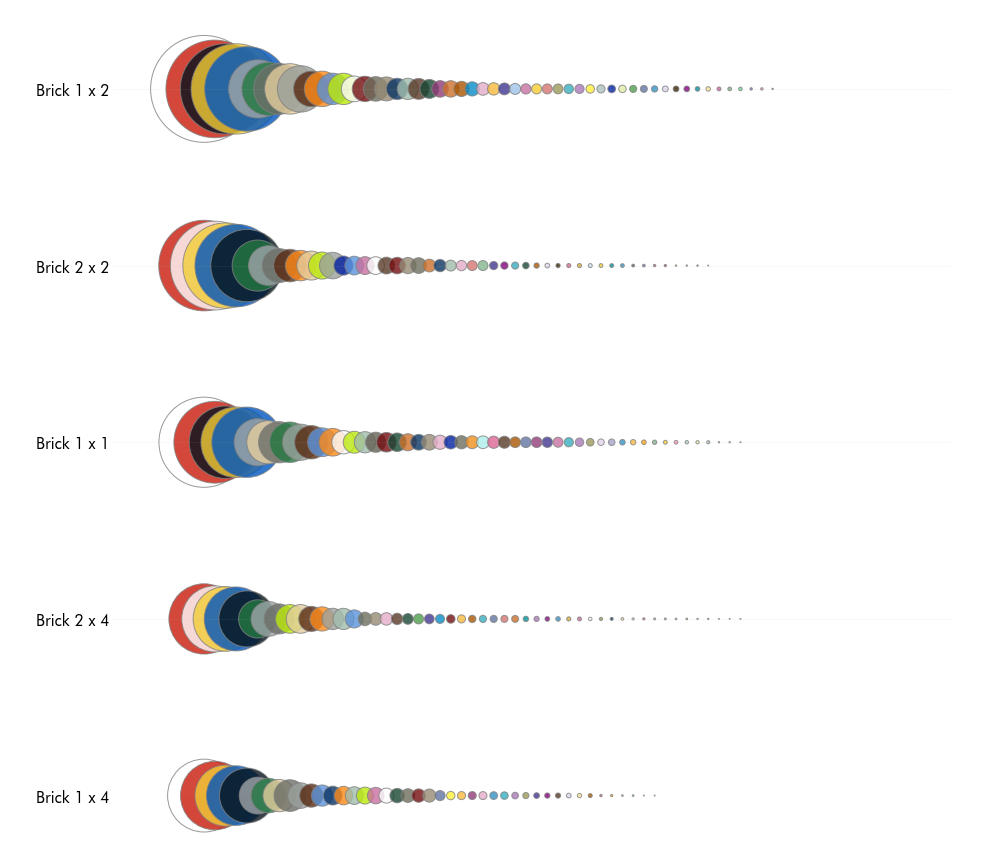

In [340]:
fig, ax = plt.subplots(figsize=(15,13))
for i,v in enumerate(major_bricks_count.T):
    col_range = len(major_bricks_count.columns)
    brick_row = major_bricks_count.loc[v].sort_values(ascending=False)
    ax.scatter(y=[i for x in range(col_range)],x=[x+5 for x in range(col_range)],
    c=['#'+x for x in brick_row.index],s=brick_row,clip_on=False,edgecolor='grey',alpha=.8)

ax.set_yticks([0,1,2,3,4])
ax.set_ylim(0,4)
ax.set_yticklabels(major_bricks_count.index,fontsize=16)
ax.set_xticks([])
    